# Problem Statment:
First problem (Task 1) is a binary image classification problem. The problem focuses on identifying the presence of cancerous cells from a 27*27*3 histopathology colon images.

In [32]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import random
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import math

In [33]:
all_img_data = pd.read_csv("data_labels_mainData.csv")
all_img_path = {os.path.basename(x) : x for x in
               glob(os.path.join("./patch_images","*.png"))}
print("Images found:", len(all_img_path), ", Total Headers" , all_img_data.shape[0])
all_img_data["imagePath"] = all_img_data["ImageName"].map(all_img_path.get)

Images found: 20280 , Total Headers 9896


In [3]:
all_img_data["CancerousClass"] = all_img_data["isCancerous"].apply(lambda x : 'Y' if x==1 else 'N')
all_img_data.sample(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,CancerousClass
5366,17234,29,17234.png,inflammatory,1,0,./patch_images/17234.png,N
478,305,5,305.png,epithelial,2,1,./patch_images/305.png,Y
473,300,5,300.png,epithelial,2,1,./patch_images/300.png,Y
6077,20545,37,20545.png,fibroblast,0,0,./patch_images/20545.png,N
2570,17548,15,17548.png,inflammatory,1,0,./patch_images/17548.png,N
5348,17213,29,17213.png,inflammatory,1,0,./patch_images/17213.png,N
4666,17259,25,17259.png,fibroblast,0,0,./patch_images/17259.png,N
8915,14006,54,14006.png,epithelial,2,1,./patch_images/14006.png,Y
8536,13269,53,13269.png,inflammatory,1,0,./patch_images/13269.png,N
7812,1020,49,1020.png,epithelial,2,1,./patch_images/1020.png,Y


<AxesSubplot:>

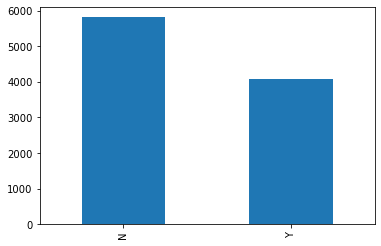

In [4]:
all_img_data['CancerousClass'].value_counts().plot.bar()

In [5]:
def create_splits(**vargs):
    
    
    
    df, test_size, target_class = vargs['dataframe'], vargs['test_size'], vargs['target_class']
    
    train_df, valid_df = train_test_split(df, test_size=test_size, stratify=df[target_class], random_state=0)
    
    prop_train = len(train_df[train_df["CancerousClass"] == "Y"]) / len(train_df)
    prop_val = len(valid_df[valid_df["CancerousClass"] == "Y"]) / len(valid_df)
    
    
    pos_idx = train_df[train_df['CancerousClass']=='Y'].index.tolist()
    neg_idx = train_df[train_df['CancerousClass']=='N'].index.tolist()
    neg_idx = random.sample(neg_idx,len(pos_idx))
    train_df = train_df.loc[pos_idx+neg_idx]
    train_df_ratio = len(train_df[train_df['CancerousClass'] == 'Y'])/len(train_df)
    print(len(train_df[train_df['CancerousClass']=='Y'].index.tolist()))
    print(len(train_df[train_df['CancerousClass']=='N'].index.tolist()))
    print(f'Percentage of Positive Cancerous samples in training set: {100.0*train_df_ratio :.2f}%')
    
    
    pos_idx = valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()
    print(len(valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()))
    neg_idx = valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()
    print(len(valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()))
   # neg_idx = random.sample(neg_idx,949)
    pos_idx = random.sample(pos_idx,292)
    valid_df = valid_df.loc[pos_idx+neg_idx]
    valid_df_ratio = len(valid_df[valid_df['CancerousClass']=='Y'])/len(valid_df)
    print(f'Percentage of Positive Cancerous samples in validation set: {100.0*valid_df_ratio :.2f}%')
    print(len(valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()))
    print(len(valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()))
    
    return train_df, valid_df

In [6]:
train_df, valid_df = create_splits(dataframe=all_img_data, test_size=0.2, target_class='CancerousClass')

3263
3263
Percentage of Positive Cancerous samples in training set: 50.00%
816
1164
Percentage of Positive Cancerous samples in validation set: 20.05%
292
1164


In [7]:
print(len(valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()))
print(len(valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()))

292
1164


In [8]:
train_df, valid_df = train_test_split(all_img_data, test_size=0.2, random_state=0)

In [9]:
train_df, valid_df = train_test_split(all_img_data, test_size=0.25,stratify=all_img_data['CancerousClass'], random_state=0)
train_ratio = len(train_df[train_df["CancerousClass"] == "Y"]) / len(train_df)
val_ratio = len(valid_df[valid_df["CancerousClass"] == "Y"]) / len(valid_df)
print(f'Initial split. Train set Cancerous: {100.0*train_ratio :.2f}%. Valid set Cancerous: {100.0*val_ratio :.2f}%')

pos_idx = train_df[train_df['CancerousClass']=='Y'].index.tolist()
neg_idx = train_df[train_df['CancerousClass']=='N'].index.tolist()
neg_idx = random.sample(neg_idx,len(pos_idx))
train_df = train_df.loc[pos_idx+neg_idx]
train_ratio = len(train_df[train_df["CancerousClass"] == "Y"]) / len(train_df)
#print(len(train_df[train_df['CancerousClass']=='Y'].index.tolist()))
#print(len(train_df[train_df['CancerousClass']=='N'].index.tolist()))
print(f'Percentage of Positive Cancerous samples in training set: {100.0*train_ratio :.2f}%')
print(f'Total number of samples in training data after resampling {len(train_df)}')
print(f'Total number of samples in training data {len(valid_df)}')

Initial split. Train set Cancerous: 41.22%. Valid set Cancerous: 41.23%
Percentage of Positive Cancerous samples in training set: 50.00%
Total number of samples in training data after resampling 6118
Total number of samples in training data 2474


In [6]:
print(len(train_df))
print(len(valid_df))


6118
2474


In [38]:
IMG_SIZE = (27,27)
BATCH_SIZE = 32

In [44]:
def img_augmentation(df_type):
    
    ## To prevent Overfitting, It Is recommended to augment data 
    ## This method will be use to increase size of only training data
    
    
    if df_type == "train":
        return ImageDataGenerator(rescale=1. / 255.0,
                                  data_format='channels_last',
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             rotation_range=15
                            )
    if df_type == "validation":
        return ImageDataGenerator(rescale=1. / 255.0)



In [45]:
def generator(df_type, df, batch_size, IMG_SIZE = (27,27)):
    
    img_aug = img_augmentation(df_type)
    df_gen = img_aug.flow_from_dataframe(dataframe = df,
                                        directory = None,
                                        x_col = 'imagePath',
                                        y_col = 'CancerousClass',
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        target_size = IMG_SIZE,
                                        batch_size = batch_size)
    
    return df_gen

In [46]:
train_gen = generator('train', train_df, 32)
val_gen = generator('validation', valid_df, 32)

Found 6526 validated image filenames belonging to 2 classes.
Found 1456 validated image filenames belonging to 2 classes.


In [11]:
## Pulling 32 random batch from valid data for testing after each epoch
valX, valy = val_gen.next()

In [12]:
print(f"ValX Shape: {valX.shape} and valY shape: {valy.shape}")

ValX Shape: (32, 27, 27, 3) and valY shape: (32,)


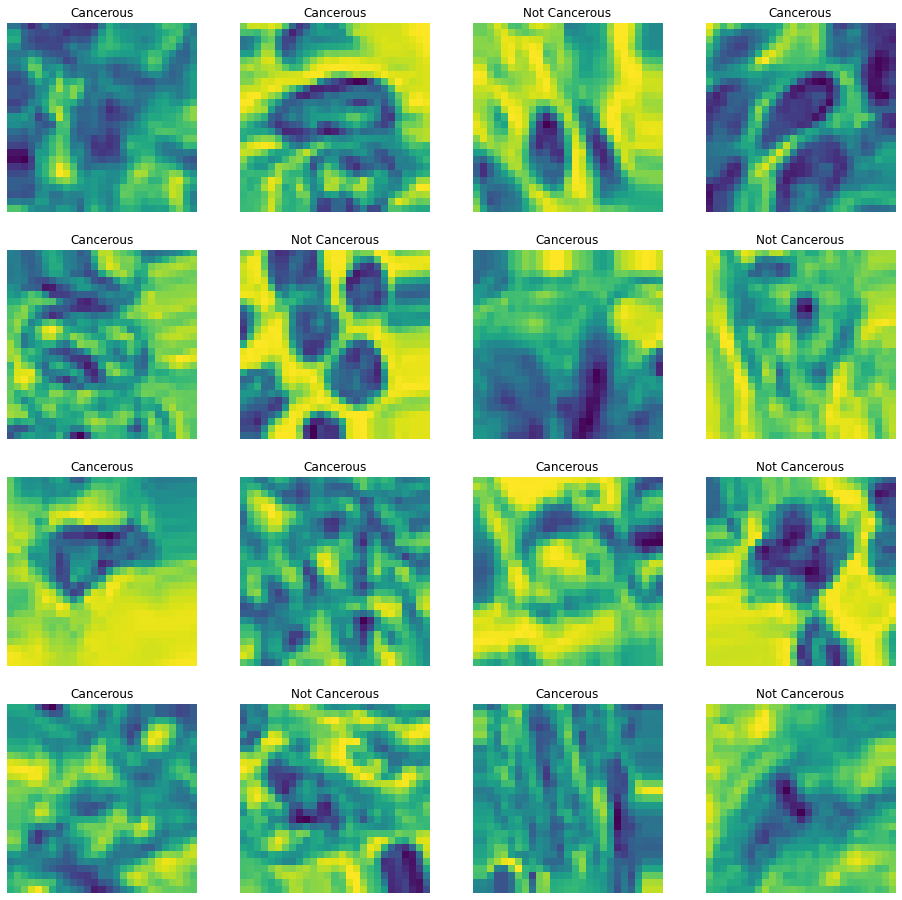

In [51]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    if c_y == 1: 
        c_ax.set_title('Cancerous')
    else:
        c_ax.set_title('Not Cancerous')
    c_ax.axis('off')

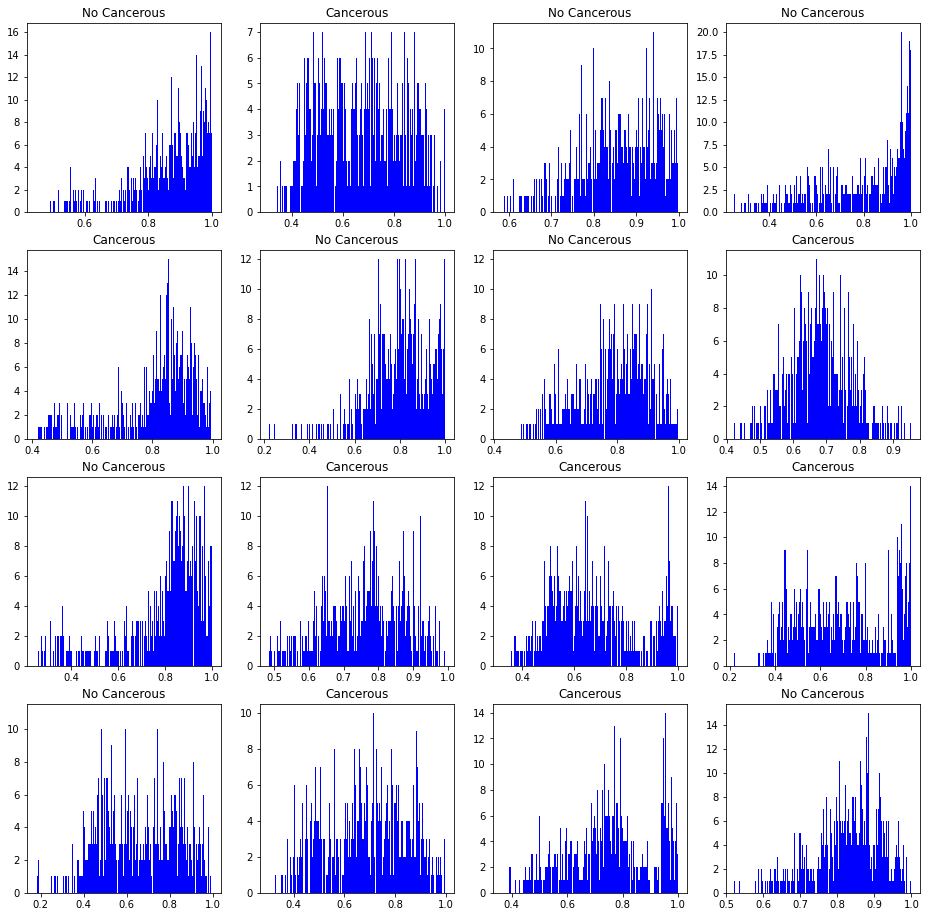

In [14]:
# t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Cancerous')
    else:
        c_ax.set_title('No Cancerous')

plt.show()

In [15]:
#VGG16
import tensorflow as tf
def my_model():
    
    reg_lambda=.001
    
    model = Sequential()
    
    model.add(Conv2D(input_shape=(27,27,3),filters=64,kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
    

In [16]:
model = my_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         2

In [17]:
# define callbacks
weight = "best.model.Cancerous_Classification.hdf5"
checkpoint = ModelCheckpoint(weight, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          mode = 'min', 
                          patience=6)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy',
#                                           patience=2,
#                                           verbose=1,
#                                           factor=0.5,
#                                           min_lr=1e-5)
callbacks = [checkpoint, earlystop]

In [18]:
optimizer =Adam(learning_rate=1e-5)#SGD(learning_rate=1e-5, momentum=0.9)
#/Nadam(learning_rate=1e-6)
loss = "binary_crossentropy"
metric = "binary_accuracy"


model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [19]:
# train your model
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valy), 
    epochs = 100,
    verbose=1,
    callbacks = callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
204/204 [==============================] - ETA: 0s - loss: 2.8194 - binary_accuracy: 0.5097
Epoch 00001: val_loss improved from inf to 2.62016, saving model to best.model.Cancerous_Classification.hdf5
204/204 [==============================] - 222s 1s/step - loss: 2.8194 - binary_accuracy: 0.5097 - val_loss: 2.6202 - val_binary_accuracy: 0.7500
Epoch 2/100
204/204 [==============================] - ETA: 0s - loss: 2.4478 - binary_accuracy: 0.5369
Epoch 00002: val_loss improved from 2.62016 to 2.24915, saving model to best.model.Cancerous_Classification.hdf5
204/204 [==============================] - 220s 1s/step - loss: 2.4478 - binary_accuracy: 0.5369 - val_loss: 2.2492 - val_binary_accuracy: 0.6875
Epoch 3/100
204/204 [==============================] - ETA: 0s - loss: 1.9421 - binary_accuracy: 0.8252
Epoch 00003: val_loss improved from 2.24915 to 1.82042, saving model to best.model.Cancerous_Class

In [20]:
# making our predictions on all validation data
valid_gen = generator('validation', valid_df, 1456)
X_val, y_val = valid_gen.next()

model.load_weights(weight)
y_pred = model.predict(X_val, verbose = True)

Found 1456 validated image filenames belonging to 2 classes.
46/46 [==============================] - 5s 113ms/step


In [21]:
## plotting some performance statistics

def history_plot(history):
    
    f = plt.figure()
    f.set_figwidth(15)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()

    plt.show()
    
    
def roc_plot(true, pred):
    
    fpr, tpr, threshold = roc_curve(true, pred, pos_label=1)
    plt.plot(fpr,tpr, color='red',lw=2)
    plt.plot([0,1],[0,1], color='navy', lw =1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Postive Rate")
    plt.title("ROC Curve")
    plt.show()
    
def pr_plot(true,pred):
    
    precision, recall, threshold = precision_recall_curve(true, pred, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return 2*(precision*recall)/(precision + recall), precision, recall, threshold



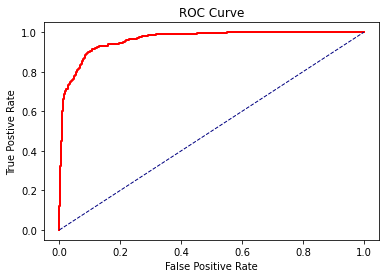

In [22]:
roc_plot(y_val, y_pred)

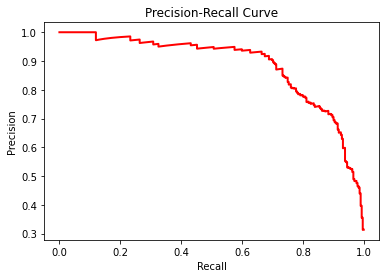

In [23]:
f1, prec, recall, thresholds = pr_plot(y_val, y_pred)

In [24]:
metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [25]:
metric_df

,f1,prec,recall,thresholds
0,0.477124,0.313305,1.000000,0.015784
1,0.475879,0.312567,0.996575,0.015850
2,0.476268,0.312903,0.996575,0.015868
3,0.476658,0.313240,0.996575,0.015870
4,0.477049,0.313578,0.996575,0.015878
...,...,...,...,...
927,0.033670,1.000000,0.017123,0.999514
928,0.027027,1.000000,0.013699,0.999538
929,0.020339,1.000000,0.010274,0.999562
930,0.013605,1.000000,0.006849,0.999653


<AxesSubplot:xlabel='thresholds'>

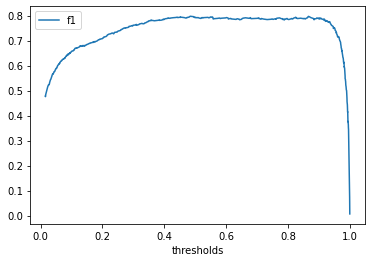

In [26]:
metric_df.plot(x='thresholds',y='f1', kind='line')

In [27]:
print("Max f1-score:", metric_df['f1'].max())
threshold = metric_df.iloc[metric_df['f1'].idxmax()]['thresholds']
print("Threshold:", threshold)

Max f1-score: 0.7975270479134465
Threshold: 0.48367640376091003


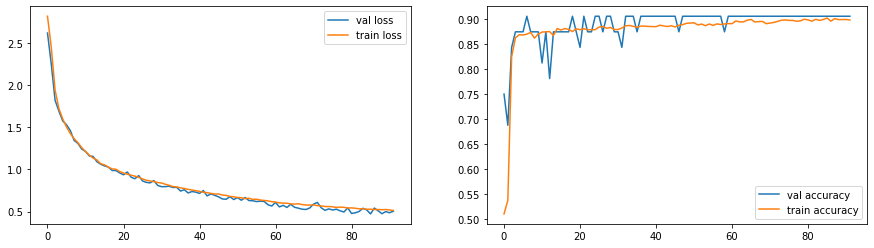

In [28]:
history_plot(history)

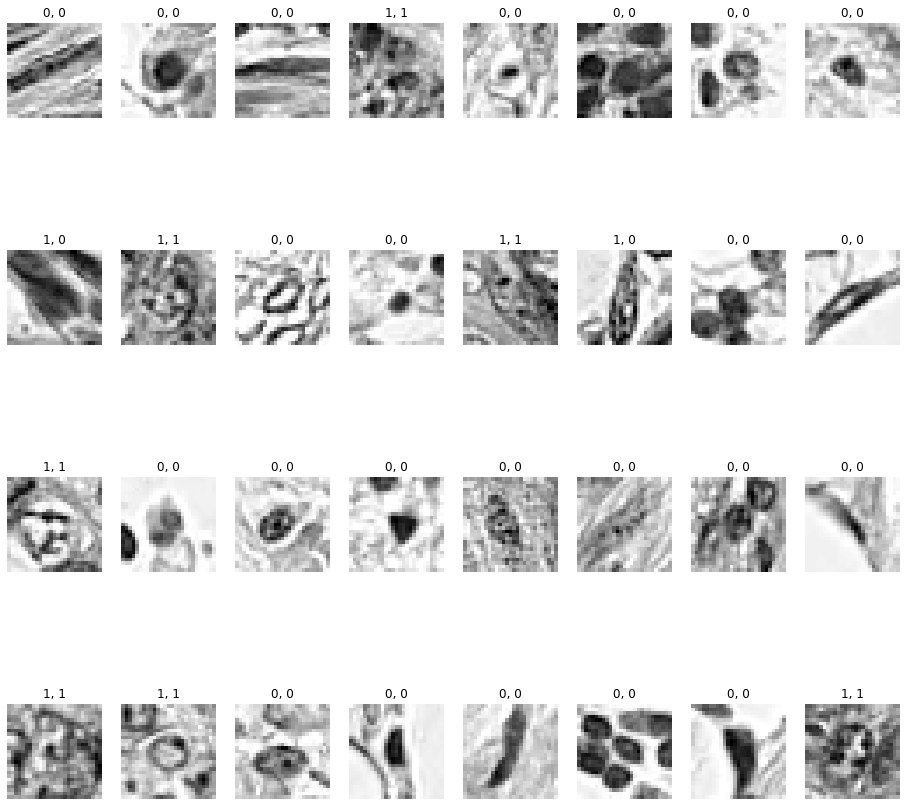

In [31]:
#threshold = 0.4

fig, m_axs = plt.subplots(4, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(X_val[0:100], y_val[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='gray')
    if c_y == 1: 
        if y_pred[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if y_pred[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1